In [1]:
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib import colors
from netCDF4 import Dataset
import pandas as pd
import properscoring as ps
import warnings
import xarray as xr
from matplotlib import cm
from utils.evaluation import plot_predictions,plot_anomaly,plot_histogram,calc_peak,calc_mean,segment_image,segment_diff
from utils.metrics import calculate_crps
# from utils.metrics import calculate_fid
import xesmf as xe
warnings.filterwarnings("ignore")

sns.set_style("white")
sns.set_palette(sns.color_palette("Paired"))

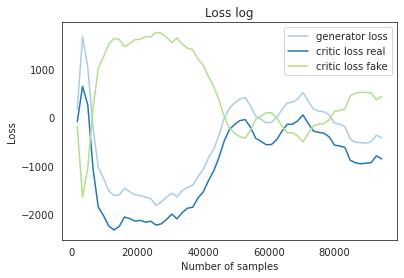

In [9]:
loss_log = pd.read_csv('/user/home/al18709/work/cgan/logs/log.txt', sep=",", header=None)[1:]
loss_log.columns = ['training_samples','disc_loss','disc_loss_real','disc_loss_fake','disc_loss_gp','gen_loss']
loss_log['training_samples'] = pd.to_numeric(loss_log['training_samples'],errors='coerce')
loss_log['gen_loss'] = pd.to_numeric(loss_log['gen_loss'],errors='coerce')
loss_log['disc_loss'] = pd.to_numeric(loss_log['disc_loss'],errors='coerce')
loss_log['disc_loss_real'] = pd.to_numeric(loss_log['disc_loss_real'],errors='coerce')
loss_log['disc_loss_fake'] = pd.to_numeric(loss_log['disc_loss_fake'],errors='coerce')


plt.plot(loss_log['training_samples'],loss_log['gen_loss'])
plt.plot(loss_log['training_samples'],loss_log['disc_loss_real'])
plt.plot(loss_log['training_samples'],loss_log['disc_loss_fake'])
plt.legend(labels=['generator loss','critic loss real','critic loss fake'])
plt.title('Loss log')
plt.xlabel('Number of samples')
plt.ylabel('Loss')
plt.savefig('figs/loss_log.png',bbox_inches='tight')


In [ ]:
# set mode
mode = 'validation'


# load datasets
real = np.load('/user/home/al18709/work/cgan_predictions/%s_real-opt.npy' % mode)[0][:,:,:,0]
pred = np.load('/user/home/al18709/work/cgan_predictions/%s_pred-opt.npy' % mode)[0][:,:,:,0]
inputs = np.load('/user/home/al18709/work/cgan_predictions/%s_input-opt.npy' % mode)[0][:,:,:,0]

train_X = np.load('/user/work/al18709/tc_data_mswep/train_X.npy')
train_y = np.load('/user/work/al18709/tc_data_mswep/train_y.npy')


# real_train = np.load('/user/home/al18709/work/cgan_predictions/train_real.npy')[0][:,:,:,0]
# pred_train = np.load('/user/home/al18709/work/cgan_predictions/train_pred.npy')[0][:,:,:,0]
# inputs_train = np.load('/user/home/al18709/work/cgan_predictions/train_input.npy')[0][:,:,:,0]
print(np.count_nonzero(np.isnan(train_y)))
print(train_y)
plot_predictions(real,pred,inputs,plot='show')



In [ ]:

# calculate conservative error
print(pred.shape)

grid_in = xr.Dataset({'longitude': np.linspace(0, 100, 100),
			'latitude': np.linspace(-50, 50, 100)
			})
	# output grid has a the same coverage at finer resolution
grid_out = xr.Dataset({'longitude': np.linspace(0, 100, 10),
				'latitude': np.linspace(-50, 50, 10)
			})

regridder = xe.Regridder(grid_in, grid_out, 'conservative')

n_images,_,_ = pred.shape

tc = np.zeros((n_images,10,10))
anomalies = np.zeros((n_images,10,10))
all_rmse = np.zeros((n_images))

for i in range(n_images):
# for i in [0]:
	tc[i,:,:] = regridder(pred[i,:,:])
	rmse = np.sqrt(np.nanmean(((inputs[i,:,:]- tc[i,:,:]) ** 2)))
	anomaly = tc[i,:,:] - inputs[i,:,:]
	anomalies[i] = anomaly
	all_rmse[i] = rmse 

print(anomalies.shape)
anomalies_mean = np.nanmean(anomalies,axis=0)
anomalies_percent = anomalies_mean / np.nanmean(tc,axis=0)
print(anomalies_percent.shape)
plot_anomaly(anomalies_percent,vmin=-5,vmax=5,plot='show',cmap='RdBu')



In [ ]:
# Plot peak railfall distributions
peak_reals = calc_peak(real)
peak_preds = calc_peak(pred)
plot_histogram(peak_reals,peak_preds,5,0.5)

mean_reals = calc_mean(real)
mean_preds = calc_mean(pred)
plot_histogram(mean_reals,mean_preds,5,0.5)

# Plot peak railfall distributions for training set
peak_reals = calc_peak(real_train)
peak_preds = calc_peak(pred_train)
plot_histogram(peak_reals,peak_preds,5,0.5)

mean_reals = calc_mean(real_train)
mean_preds = calc_mean(pred_train)
plot_histogram(mean_reals,mean_preds,5,0.5)


In [ ]:
# calc means etc
mean_real = np.mean(real,axis=0)
mean_pred = np.mean(pred,axis=0)
mean_anom = mean_pred - mean_real
plot_anomaly(mean_anom,cmap='RdBu',plot='show')

std_real = np.std(real,axis=0)
std_pred = np.std(pred,axis=0)
std_anom = std_pred - std_real
plot_anomaly(std_anom,cmap = 'RdBu',plot='show')

# print(mean_real,mean_pred)
# print(std_real,std_pred)

In [ ]:
# Calculate CRPS
crps = calculate_crps(real,pred)
print(crps.shape)
plot_anomaly(np.nanmean(crps,axis=0),vmin=0,vmax=8,plot='show',cmap='plasma')
print(np.nanmean(crps))

In [ ]:
# Plot Scatter
print(pred.shape)
print(real.shape)

pred_vector = pred.ravel()
real_vector = real.ravel()

print(pred_vector.shape)

plt.scatter(pred_vector,real_vector,s=0.2)
plt.show()


In [ ]:
# Plot 2D image moments
from skimage import measure, filters

m = measure.moments(pred[2,:,:])

# edge detection?
es = filters.sobel(pred[2,:,:])
mc = measure.moments_central(es)
nu = measure.moments_normalized(mc)
hu = measure.moments_hu(nu)

plot_anomaly(real[2,:,:],vmin=0,vmax=30,plot='show',cmap='Blues')
plot_anomaly(filters.sobel(real[2,:,:]),vmin=0,vmax=5,plot='show',cmap='Blues')
plot_anomaly(pred[2,:,:],vmin=0,vmax=30,plot='show',cmap='Blues')
plot_anomaly(es,vmin=0,vmax=5,plot='show',cmap='Blues')

# print(hu)
print(hu)
es = filters.sobel(real[2,:,:])
mc = measure.moments_central(pred[0,:,:])
nu = measure.moments_normalized(mc)
hu = measure.moments_hu(nu)
print(hu)
# print(measure.blur_effect(pred[0.:,:]))

In [ ]:
# image segmentation

cmap = cm.get_cmap('Blues',4)


im = pred[-1,:,:]
im = segment_image(im)
plot_anomaly(im,cmap,plot='plot',vmin=0,vmax=3)

im = real[-1,:,:]
im = segment_image(im)
plot_anomaly(im,cmap,plot='plot',vmin=0,vmax=3)


anomalies = np.zeros((n_images,100,100))
all_rmse = np.zeros((n_images))

correct_0 = np.zeros(n_images)
correct_1 = np.zeros(n_images)
correct_2 = np.zeros(n_images)
correct_3 = np.zeros(n_images)

no_0 = np.zeros(n_images)
no_1 = np.zeros(n_images)
no_2 = np.zeros(n_images)
no_3 = np.zeros(n_images)

light_0 = np.zeros(n_images)
light_1 = np.zeros(n_images)
light_2 = np.zeros(n_images)
light_3 = np.zeros(n_images)

medium_0 = np.zeros(n_images)
medium_1 = np.zeros(n_images)
medium_2 = np.zeros(n_images)
medium_3 = np.zeros(n_images)

heavy_0 = np.zeros(n_images)
heavy_1 = np.zeros(n_images)
heavy_2 = np.zeros(n_images)
heavy_3 = np.zeros(n_images)

for i in range(n_images):
	pred_im = segment_image(pred[i,:,:])
	real_im = segment_image(real[i,:,:])
	rmse = np.sqrt(np.nanmean(((real_im- pred_im) ** 2)))
	anomaly = pred_im - real_im
	anomalies[i] = anomaly
	all_rmse[i] = rmse

	# low_to_no = np.where(real_im == 0,0,np.nan)

	correct,no,light,medium,heavy = segment_diff(real_im,pred_im,rain=0)
	correct_0[i],no_0[i],light_0[i],medium_0[i],heavy_0[i] = correct,no,light,medium,heavy

	correct,no,light,medium,heavy = segment_diff(real_im,pred_im,rain=1)
	correct_1[i],no_1[i],light_1[i],medium_1[i],heavy_1[i] = correct,no,light,medium,heavy

	correct,no,light,medium,heavy = segment_diff(real_im,pred_im,rain=2)
	correct_2[i],no_2[i],light_2[i],medium_2[i],heavy_2[i] = correct,no,light,medium,heavy

	correct,no,light,medium,heavy = segment_diff(real_im,pred_im,rain=3)
	correct_3[i],no_3[i],light_3[i],medium_3[i],heavy_3[i] = correct,no,light,medium,heavy

	

rain = ['Low to no','Light','Medium','Heavy']
low = [correct_0.mean(),no_1.mean(),no_2.mean(),no_3.mean()]
light = [light_0.mean(),correct_1.mean(),light_2.mean(),light_3.mean()]
medium = [medium_0.mean(),medium_1.mean(),correct_2.mean(),medium_3.mean()]
heavy = [heavy_0.mean(),heavy_1.mean(),heavy_2.mean(),correct_3.mean()]


print(low)
print(light)
print(medium)
print(heavy)


plt.bar(rain, low, width=0.8, label='Low to no',color='#ecc8af', bottom=light)
plt.bar(rain, light, width=0.8, label='Light', color = '#e7ad99', bottom=medium)
plt.bar(rain, medium, width=0.8, label='Medium',color = '#ce796b', bottom=heavy)
plt.bar(rain, heavy, width=0.8, color = '#495867',label='Heavy')

plt.xlabel("Rain Type")
plt.ylabel("Score?")
plt.legend(rain)
# plt.bar(ind, bronzes, width=0.8, label='bronzes', color='#CD853F')
plt.show()
# plot_anomaly(low_to_no_pred,plot='show',vmin = -3,vmax=3,cmap='RdBu')

anomalies_mean = np.nanmean(anomalies,axis=0)
print(anomalies_mean.shape)

# plot_anomaly(anomaly,plot='show',vmin = -3,vmax=3,cmap='RdBu')
# plot_anomaly(anomalies_mean,plot='show',cmap='RdBu')

	


In [ ]:
# compare imerg and mswep

imerg = np.load('/user/home/al18709/work/tc_Xy/imerg/y_2014068S16169.npy')

mswep = np.load('/user/home/al18709/work/tc_Xy/mswep/y_2014068S16169.npy')

print(imerg.shape)
print(mswep.shape)

plot_anomaly(imerg[2,:,:],cmap='Blues',vmin=0,vmax=50,plot='plot')
plot_anomaly(mswep[2,:,:],cmap='Blues',vmin=0,vmax=50,plot='plot')

print(np.load('/user/home/al18709/work/tc_data_imerg/train_y.npy').shape)
print(np.load('/user/home/al18709/work/tc_data_mswep/train_y.npy').shape)

In [ ]:
# accumulated rainfall

